In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [41]:
data = pd.read_csv("breast_cancer.csv")
data.head()

,ID,diagnosis,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,...,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [42]:
data.drop("ID", axis=1, inplace=True) # Drop ID as it is not relevant information
y = data.pop("diagnosis")
y.replace(["B", "M"], [0, 1], inplace=True)

In [43]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

In [44]:
pca = PCA(n_components=3) # Reduce the dimensions of the data down to 3
X_pca = pca.fit_transform(X_scaled)

total = sum(pca.explained_variance_ratio_) * 100
print(f"""PCA dimension variance ratio: {pca.explained_variance_ratio_ * 100}
Total: {total}
Percentage of data not explained by dimensions:  {100 - total}""")

PCA dimension variance ratio: [44.27202561 18.97118204  9.39316326]
Total: 72.6363709087928
Percentage of data not explained by dimensions:  27.3636290912072


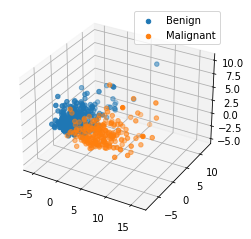

In [45]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(X_pca[y==0, 0], X_pca[y==0, 1], X_pca[y==0, 2], label="Benign")
ax.scatter(X_pca[y==1, 0], X_pca[y==1, 1], X_pca[y==1, 2], label="Malignant")
ax.legend()
plt.show()


In [46]:
X_train, X_test, y_train, y_test \
= train_test_split(X_scaled, y, test_size=0.25, stratify=y) # Non-dimensionality reduced data

X_train_pca, X_test_pca, y_train_pca, y_test_pca \
= train_test_split(X_pca, y, test_size=0.25, stratify=y) # Dimensionality reduced data (to 3)

In [47]:
n_estimators = np.arange(5, 500, step=5)
criterion = ["gini", "entropy"]
max_depth = list(np.arange(5, 50, step=5)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = np.arange(1, 5, step=1)
max_features = ["auto", "sqrt", "log2", None]

param_grid = {
    "n_estimators" : n_estimators,
    "criterion" : criterion,
    "max_depth" : max_depth,
    "min_samples_split" : min_samples_split,
    "min_samples_leaf" : min_samples_leaf,
    "max_features" : max_features
}

random_cv_x = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=200, cv=3, scoring="accuracy", 
n_jobs=-1)
random_cv_x.fit(X_train, y_train)

random_cv_x_pca = RandomizedSearchCV(RandomForestClassifier(), param_grid, n_iter=200, cv=3, scoring="accuracy", 
n_jobs=-1)
random_cv_x_pca.fit(X_train_pca, y_train_pca)

print(f"""Best params for X_train:
{random_cv_x.best_params_}
Best params for X_train_pca:
{random_cv_x_pca.best_params_}""")

Best params for X_train:
{'n_estimators': 35, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini'}
Best params for X_train_pca:
{'n_estimators': 220, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40, 'criterion': 'gini'}


In [67]:
rfc = RandomForestClassifier(n_estimators=35, criterion="gini", min_samples_split=2, min_samples_leaf=4, max_features="log2", max_depth=None)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=4, n_estimators=35)

In [68]:
rfc_pca = RandomForestClassifier(n_estimators=220, criterion="gini", min_samples_split=2, min_samples_leaf=1, max_features=None, max_depth=40)
rfc_pca.fit(X_train_pca, y_train_pca)

RandomForestClassifier(max_depth=40, max_features=None, n_estimators=220)

In [70]:
print(f"""Testing accuracy on non-dimensionality reduced data: {rfc.score(X_test, y_test)}
Testing accuracy on dimensionality reduced data: {rfc_pca.score(X_test_pca, y_test_pca)}""")

Testing accuracy on non-dimensionality reduced data: 0.9370629370629371
Testing accuracy on dimensionality reduced data: 0.9440559440559441
